Markdown
<div style="background-color: #f9f9f9; border: 5px solid #0AFFFF; border-radius: 15px; padding: 15px; text-align: center;">
    <h3 style="font-family: Arial, sans-serif; font-size: 30px; font-weight: bold; color: #000000; margin: 0 auto;">
        📚 Library
    </h3>
</div>


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#basics
import re
import numpy as np
import pandas as pd

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

#split data
from sklearn.model_selection import train_test_split

# Train a similarity model, such as cosine similarity, using the TF-IDF vectors:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression

# model evaluation
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

# save model
import joblib



In [3]:
TRAIN_DATA_PATH='/content/drive/MyDrive/FSDS Assessment/data/train.csv'
TEST_DATA_PATH='/content/drive/MyDrive/FSDS Assessment/data/test (1).csv'

In [4]:
# Load the dataset
df = pd.read_csv(TRAIN_DATA_PATH)

# Inspect the dataset
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
df.shape

(404290, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [7]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [8]:
df.dropna(inplace=True)

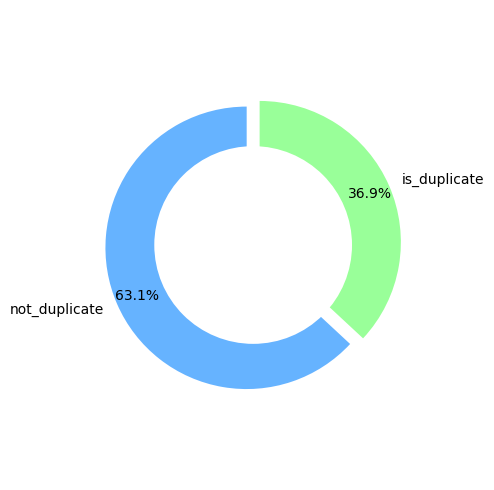

In [9]:
# number of customers who churned and who did not churn
targets = df['is_duplicate'].value_counts()

# pie chart to visualize the distribution of customer churn
labels = ['not_duplicate', 'is_duplicate']
sizes = targets.values.tolist()

#colors
colors = ['#66b3ff', '#99ff99'] 

 
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = (0.05,0.05))
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout();

In [10]:
#lower casing
def lower_casing(text):
  text=text.lower()

  return text

In [11]:
df['new_ques1']=df['question1'].apply(lower_casing)
df['new_ques2']=df['question2'].apply(lower_casing)

In [12]:
def remove_symbols(text):
    # Remove symbols using regular expressions
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    return cleaned_text

# Apply symbol removal to the text data
df['new_ques1'] = df['new_ques1'].apply(remove_symbols)
df['new_ques2'] = df['new_ques2'].apply(remove_symbols)


In [13]:
def remove_numbers(text):
    # Remove numbers using regular expressions
    cleaned_text = re.sub(r'\d+', '', text)
    return cleaned_text

# Apply number removal to the text data
df['new_ques1'] = df['new_ques1'].apply(remove_numbers)
df['new_ques2'] = df['new_ques2'].apply(remove_numbers)


In [14]:
# Download stopwords and lemmatizer if not already downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Remove stopwords and perform lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the text data
df['new_ques1'] = df['new_ques1'].apply(preprocess_text)
df['new_ques2'] = df['new_ques2'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
# Count the occurrences of each category in the `is_duplicate` column
category_counts = df['is_duplicate'].value_counts()

# Determine the minimum count among the categories
min_count = category_counts.min()

# Take a random sample of each category with the minimum count
sampled_data = df.groupby('is_duplicate').apply(lambda x: x.sample(n=int(min_count/10), random_state=42)).reset_index(drop=True)

In [16]:
X = sampled_data[['new_ques1', 'new_ques2']]
y = sampled_data['is_duplicate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# Convert text data into numerical representations using TF-IDF vectorization:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train['new_ques1'] + ' ' + X_train['new_ques2'])
X_test_tfidf = tfidf.transform(X_test['new_ques1'] + ' ' + X_test['new_ques2'])


In [18]:
# Calculate cosine similarity
cosine_sim = cosine_similarity(X_train_tfidf, X_test_tfidf)


In [24]:
# Use cosine similarity as a feature
X_train_features = pd.DataFrame(cosine_sim)


In [26]:
X_train_features.shape

(23881, 5971)

In [27]:
y_train.shape

(23881,)

In [28]:
# Train a classification model
model = LogisticRegression()
model.fit(X_train_features, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [30]:
# Calculate cosine similarity for the test set
cosine_sim_test = cosine_similarity(X_test_tfidf, X_test_tfidf)

# Use cosine similarity as a feature for the test set
X_test_features = pd.DataFrame(cosine_sim_test)

# Make predictions
predictions = model.predict(X_test_features)

In [31]:
accuracy_score(predictions, y_test)

0.6814603918941551

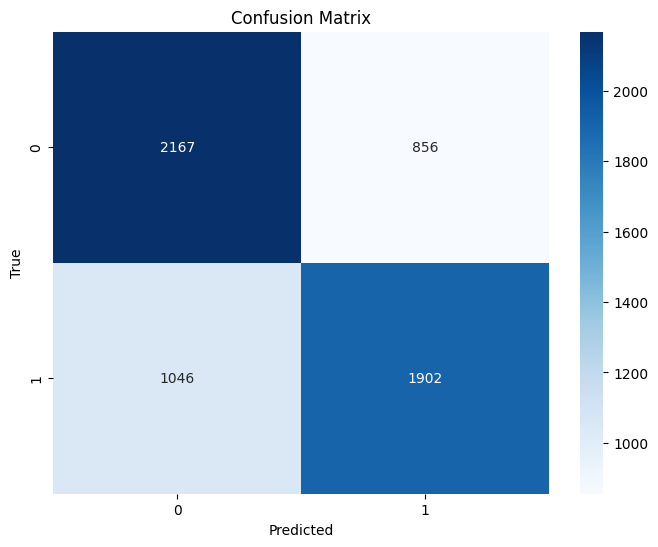

In [33]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [39]:
# Save the model to a file
joblib.dump(model, '/content/drive/MyDrive/FSDS Assessment/model/model.pkl')

['/content/drive/MyDrive/FSDS Assessment/model/model.pkl']

In [15]:
# load model
# Load the saved model
model = joblib.load('model/model.pkl')
vectorizer = joblib.load('model/vectorizer.joblib')

In [4]:
# Preprocess function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    text = re.sub(r"\d+", "number", text)
    stopwords_list = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords_list]
    text = ' '.join(words)
    return text

In [5]:
test_df = pd.read_csv("data/test.csv")

test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [6]:
question1 = test_df.question1[0]
question2 = test_df.question2[0]

In [17]:
# Preprocess the inputs
question1 = preprocess_text(question1)
question2 = preprocess_text(question2)

# Create DataFrame with preprocessed questions
input_data = pd.DataFrame({'Question1': [question1], 'Question2': [question2]})

# Apply TfidfVectorizer
tfidf_matrix = vectorizer.fit_transform(input_data['Question1'] + ' ' + input_data['Question2'])



In [19]:
tfidf_matrix.shape

(1, 11)

In [21]:
# Calculate cosine similarity and convert to DataFrame
similarity_matrix = cosine_similarity(tfidf_matrix)
# similarity_df = pd.DataFrame(similarity_matrix, columns=range(5971))

In [22]:
similarity_matrix

array([[1.]])

In [12]:
similarity_df

,0,1
0,1.000000,0.278184
1,0.278184,1.000000
